<a href="https://colab.research.google.com/github/EderCabascango/Accidentes_Cerebro_Vasculares/blob/main/Accidentes_Cerebro_Vasculares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDDICIÓN DE ACCIDENTES CEREBRO VASCULARES (Stroke Prediction)**

## 1. Introducción
Un accidente cerebrovascular (stroke) ocurre cuando el flujo sanguíneo al cerebro se interrumpe o reduce, provocando daño en las células cerebrales.  
Detectarlo a tiempo es fundamental para reducir complicaciones y salvar vidas.

**Objetivo:**  
Construir modelos de Machine Learning que permitan predecir la probabilidad de que un paciente sufra un stroke en base a factores médicos y demográficos.

**Dataset**
Obtenido desde Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset, se tiene algunos casos etiquetados con afecciones positivas en este tipo de patologías. Mediante el analisis de sus variables se intenta predecir posibles casos positivos.

# **EDA**



## 2. Exploración de Datos (EDA)

En esta sección analizamos las características del dataset y su distribución.  
El objetivo es identificar valores nulos, distribuciones de variables y la relación entre las variables predictoras y el objetivo (`stroke`).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score
import joblib

In [ ]:
#El primer paso es descargar el archivo, guardarlo en drive y finalmente leerlo con pd.read_csv.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === CARGA DE DATOS ===
df = pd.read_csv('/content/drive/MyDrive/DataSets/healthcare-dataset-stroke-data.csv')

In [ ]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Una vez montado el dataset se describe las variables con la función info, donde se detalla las caracteristicas del Data Frame encontrando:

1. id - El id del paciente
2. gender - Genero
3. age - Edad
4. hypertension - Clasificacion de hipertención (Yes or No)
5. heart_diseas -, Cardiopatias (Yes or No)
6. ever_married - Si ha contraído matrimonio (Yes or No)
7. work_type - El tipo de trabajo que realiza
8. Residence_type - El lugar de residencia
9. avg_glocose_level - El promedio del nivel de glucosa
10. bmi - Indice de masa corporal
11. smoking_status - Si es fumador (Yes or No)
12. stroke - Accidente cerebro vascular (Yes or No)

In [ ]:
# Valores nulos
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


**Completitud de los datos**
En cuanto a la completitud de los datos, se ha encontrado que en el apartado bmi contiene 201 campos nulos.

In [ ]:
nan_counts = df.isnull().sum()
print(nan_counts)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Se verifica la distribución de dicha variable para tener una idea de que metodo elegir para imputar valores.

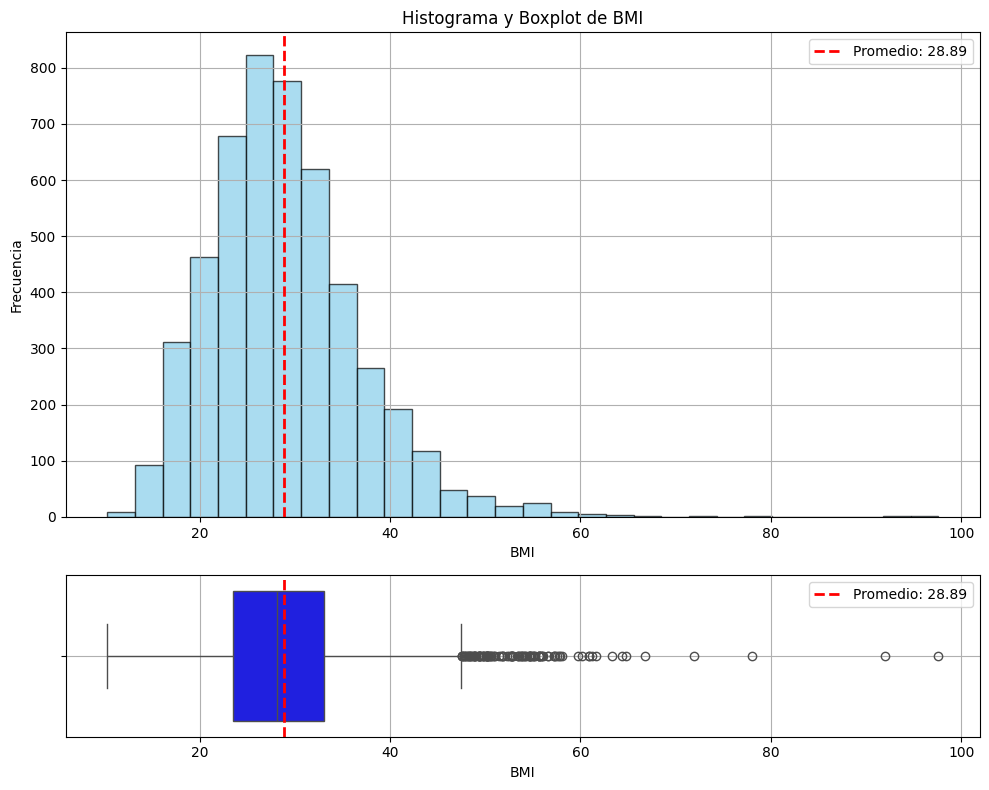

In [ ]:
# Filtrar valores nulos para evitar errores
df_clean = df['bmi'].dropna()

# Calcular el promedio
mean_value = np.mean(df_clean)

# Crear figura y subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

axes[0].hist(df_clean, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
axes[0].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Promedio: {mean_value:.2f}')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Histograma y Boxplot de BMI')
axes[0].legend()
axes[0].grid(True)

sns.boxplot(x=df_clean, color='blue', ax=axes[1])
axes[1].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Promedio: {mean_value:.2f}')
axes[1].set_xlabel('BMI')
axes[1].legend()
axes[1].grid(True)

# Ajustar espacio entre subplots
plt.tight_layout()
plt.show()

Tras realizar el analisis y observar que el bmi es una de los campos mas relevantes para detectar los ataques cerebro vasculares, he decidido abordar los valores NAN en este campo rellenandolos con el valor medio, a consideración dejaría que en posteriori realizar una regresión linear o un random forest para poder predecir estos valores.

In [ ]:
#Rellena con la mediana los valores NAN
mean_value = df['bmi'].mean()
df['bmi'].fillna(mean_value, inplace=True)

/tmp/ipython-input-3405475836.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(mean_value, inplace=True)


In [ ]:
nan_counts = df.isnull().sum()
print(nan_counts)

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Dado que el dataset original contiene valores que ya se encuentra con labels como 0 y 1 antes de poder verificar anomalías los volvemos a columnas categoricas Yes o No para poder graficarlos

In [ ]:
#cambiar valores por yes y no
columnas_a_cambiar = ['hypertension', 'heart_disease', 'stroke']
df[columnas_a_cambiar] = df[columnas_a_cambiar].replace({0: 'No', 1: 'Yes'})
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.600000,formerly smoked,Yes
1,51676,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Yes
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.500000,never smoked,Yes
3,60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.400000,smokes,Yes
4,1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Yes


In [ ]:
#convertimos la columna age en un entero
df['age'] = df['age'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 479.2+ KB


In [ ]:
#gráfico de cajas de los valores númericos
def plot_boxplots(df):
    # Filtrar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No hay columnas numéricas en el DataFrame.")
        return

    # Definir el número de columnas y calcular las filas necesarias
    num_cols = 4
    num_rows = math.ceil(len(numeric_cols) / num_cols)

    # Configuración del tamaño de la figura
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil iteración

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    # Eliminar los ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

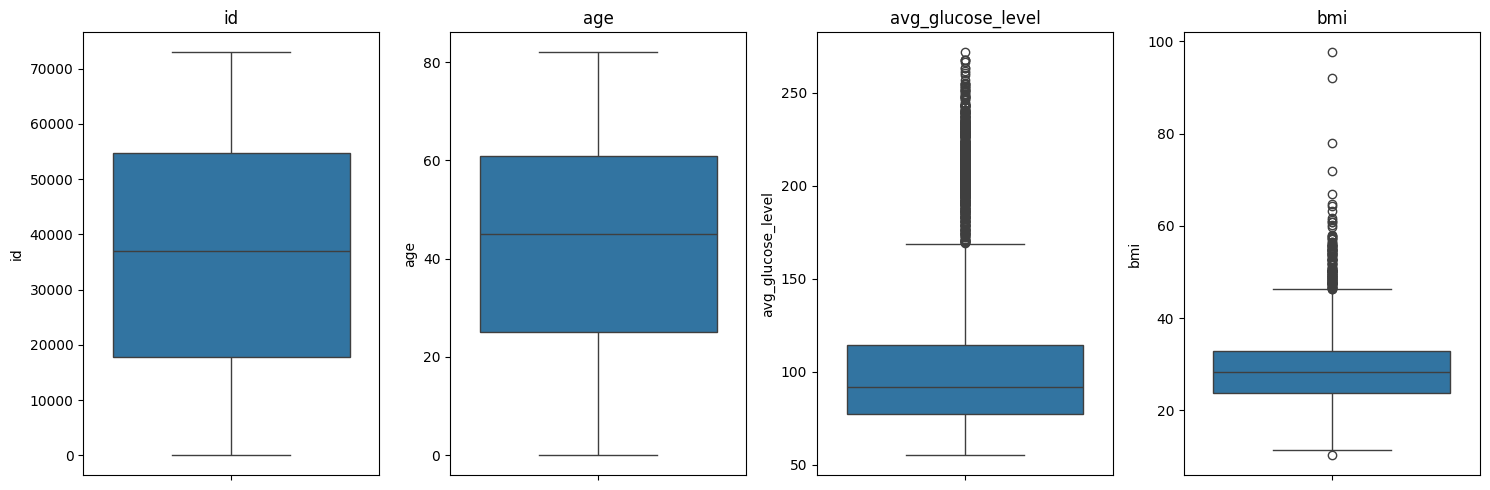

In [ ]:
plot_boxplots(df)

In [ ]:
# histogramas de los valores númericos
def plot_histograms(df):
    # Filtrar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No hay columnas numéricas en el DataFrame.")
        return

    num_cols = 4
    num_rows = math.ceil(len(numeric_cols) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil iteración

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])  # kde=True agrega una línea de densidad
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    # Elimina los ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

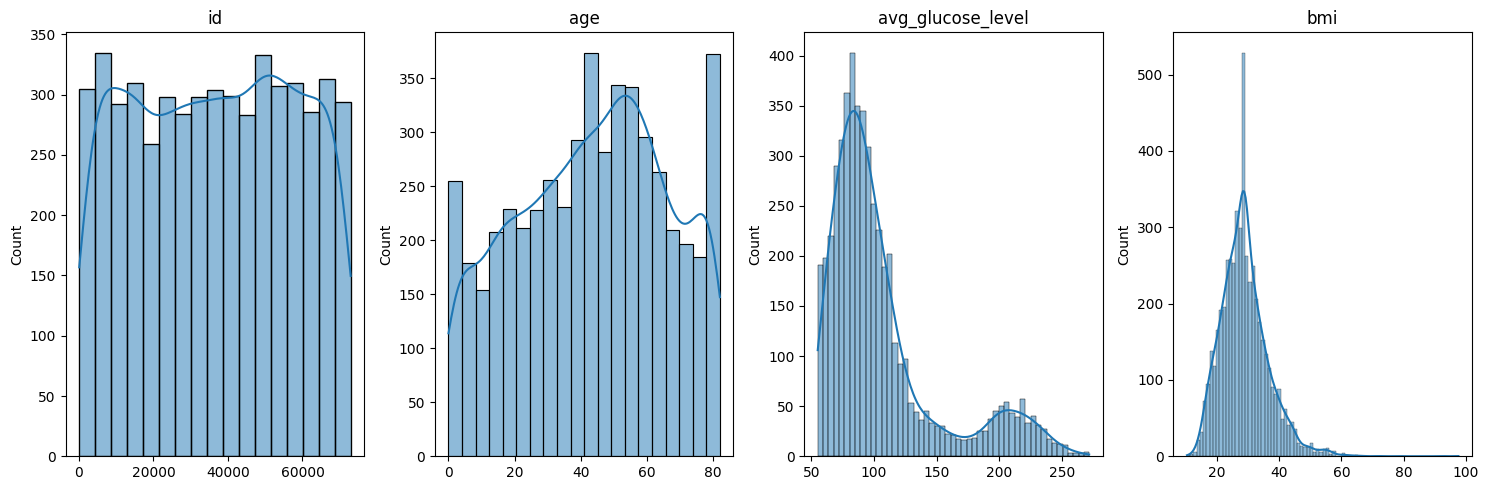

In [ ]:
plot_histograms(df)

In [ ]:
df.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.215264,106.147677,28.893237
std,21161.721625,22.633866,45.283560,7.698018
min,67.000000,0.000000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.800000
50%,36932.000000,45.000000,91.885000,28.400000
75%,54682.000000,61.000000,114.090000,32.800000
max,72940.000000,82.000000,271.740000,97.600000


De inicio asumí que en edad al contener valores como 0 estaban mal ingresados, pero tras observar la categoría children en el apartado work_type es deducido que se tratan de ninos.

In [ ]:
from math import ceil
def graficos_eda_categoricos(cat, columnas_excluir=[]):
    # Filtrar el DataFrame para excluir las columnas numéricas y las especificadas
    cat = cat.drop(columns=columnas_excluir)  # Excluir las columnas manualmente
    cat = cat.select_dtypes(exclude=['number'])  # Excluir las columnas numéricas

    filas = ceil(cat.shape[1] / 3)
    f, ax = plt.subplots(nrows=filas, ncols=3, figsize=(12, filas * 3))
    ax = ax.flat

    # Crea los gráficos de barras para cada columna
    for cada, variable in enumerate(cat.columns):
        cat[variable].value_counts().plot.barh(ax=ax[cada], color='skyblue')
        ax[cada].set_title(variable, fontsize=10, fontweight="bold")  # Fuente más pequeña
        ax[cada].tick_params(labelsize=8)  # Ajustamos el tamaño de las etiquetas

    # Ajusta el layout para evitar superposición
    plt.tight_layout()
    plt.show()

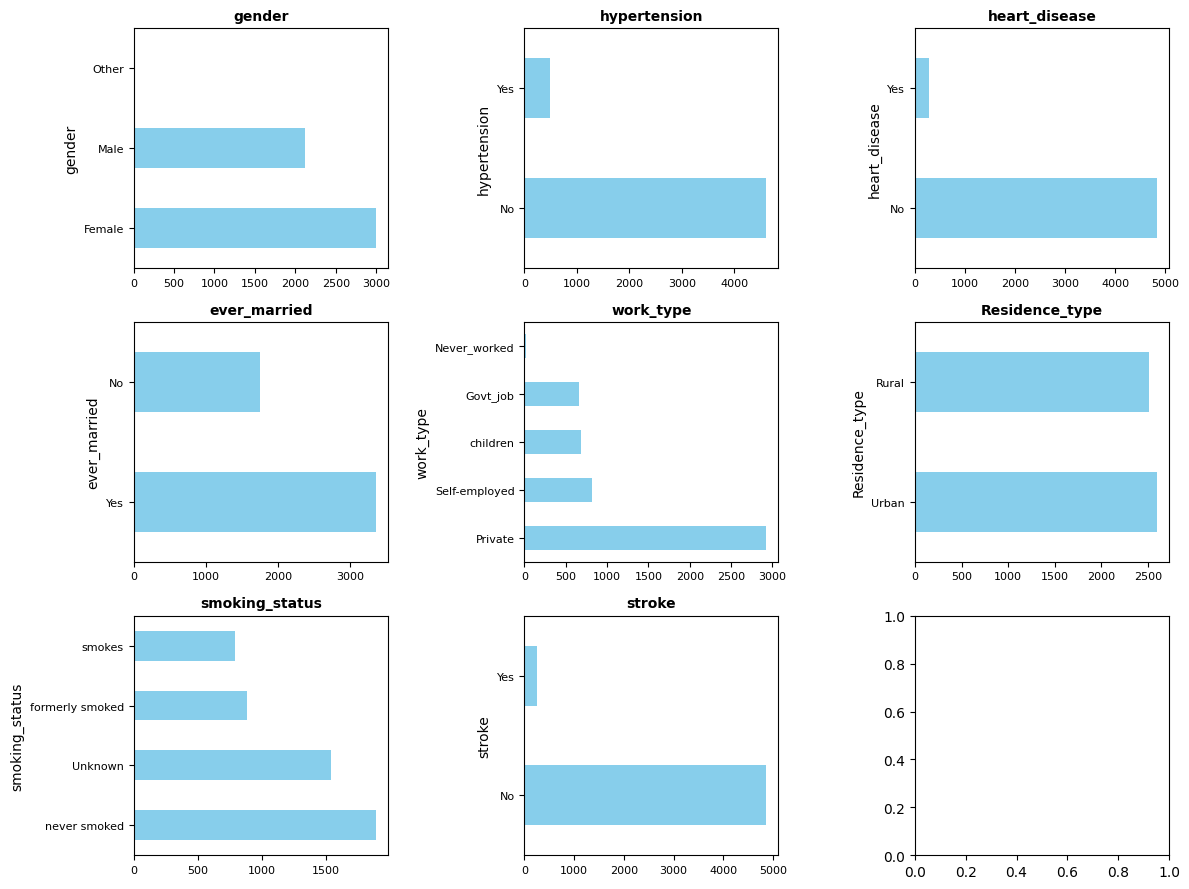

In [ ]:
graficos_eda_categoricos(df)

/tmp/ipython-input-3172770355.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_valores.index, y=conteo_valores.values, palette="pastel")


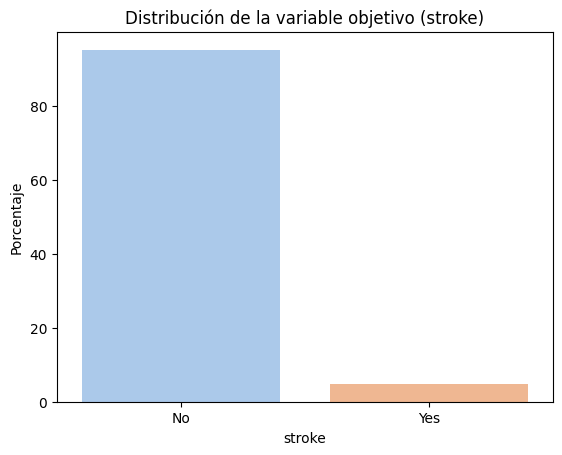

stroke
No     95.127202
Yes     4.872798
Name: proportion, dtype: float64


In [ ]:
# Distribución de la variable objetivo
conteo_valores = df['stroke'].value_counts(normalize=True) * 100
sns.barplot(x=conteo_valores.index, y=conteo_valores.values, palette="pastel")
plt.title("Distribución de la variable objetivo (stroke)")
plt.ylabel("Porcentaje")
plt.show()

print(conteo_valores)

Podemos observar que la variable objetivo se encuentra sumamente desbalanceada casí un 96% a 4% de esta lo cual nos puede contraer problemas al momento de realizar el entrenamiento del modelo

# **PREPROCESAMIENTO DE DATOS**

## 3. Preprocesamiento de Datos

En esta sección se aplican transformaciones necesarias para preparar los datos antes del modelado:

- Escalado de variables numéricas.
- Codificación de variables categóricas.
- Manejo del desbalanceo de clases.

3.1 Dado que esta es la segunda versión de este proyecto se ha añadido features adicionales para mejorar la precisón del proyecto, se agrupo las edades puesto que esto clasifica por grupos y nos ayuda en las predicciones al añadir datos relacionados.

In [ ]:
# Convertimos nuevamente las columnas codificadas si hiciste reemplazos previos
df['hypertension'] = df['hypertension'].replace({'Yes': 1, 'No': 0})
df['heart_disease'] = df['heart_disease'].replace({'Yes': 1, 'No': 0})

# 1. Edad agrupada
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 40, 60, 120],
                         labels=['Niño', 'Joven', 'Adulto', 'Mayor'])

# 2. IMC agrupado
df['bmi_group'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, 29.9, 100],
                         labels=['Bajo', 'Normal', 'Sobrepeso', 'Obeso'])

# 3. Interacción hipertensión + cardiopatía
df['hiper_cardio'] = df['hypertension'].astype(str) + "_" + df['heart_disease'].astype(str)

# Verifica que se crearon
print(df[['age', 'age_group', 'bmi', 'bmi_group', 'hiper_cardio']].head())


   age age_group        bmi  bmi_group hiper_cardio
0   67     Mayor  36.600000      Obeso          0_1
1   61     Mayor  28.893237  Sobrepeso          0_0
2   80     Mayor  32.500000      Obeso          0_1
3   49    Adulto  34.400000      Obeso          0_0
4   79     Mayor  24.000000     Normal          1_0


/tmp/ipython-input-406578122.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['hypertension'] = df['hypertension'].replace({'Yes': 1, 'No': 0})
/tmp/ipython-input-406578122.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['heart_disease'] = df['heart_disease'].replace({'Yes': 1, 'No': 0})


In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,bmi_group,hiper_cardio
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,Yes,Mayor,Obeso,0_1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Yes,Mayor,Sobrepeso,0_0
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,Yes,Mayor,Obeso,0_1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.400000,smokes,Yes,Adulto,Obeso,0_0
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Yes,Mayor,Normal,1_0


In [ ]:
# ESCALADORES
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Standard Scaler
escalador = StandardScaler()
df[numeric_cols] = escalador.fit_transform(df[numeric_cols]) # Tomar valores numericos

In [ ]:
# Eliminar columna ID (no aporta valor predictivo)
df = df.drop('id', axis=1)

In [ ]:
#Verifica los valores unicos
df.nunique()

,0
gender,3
age,83
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3979
bmi,419
smoking_status,4


**ENCODING**

In [ ]:
# Excluir la columna 'stroke' para OneHotEncoding
df_sin_stroke = df.drop(columns=['stroke'])

# Realizar OneHotEncoding en las columnas tipo object
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` para obtener un DataFrame
df_encoded = encoder.fit_transform(df_sin_stroke.select_dtypes(include=['object']))

# Convertir el resultado en un DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(df_sin_stroke.select_dtypes(include=['object']).columns))

# Aplicar LabelEncoder a la columna 'stroke'
label_encoder = LabelEncoder()
df['stroke'] = label_encoder.fit_transform(df['stroke'])

# Concatenar los DataFrames: los datos codificados y la columna 'stroke' con LabelEncoding
df_final = pd.concat([df_encoded, df['stroke']], axis=1)

# Ver el resultado
df_final.head()

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,...,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hiper_cardio_0_0,hiper_cardio_0_1,hiper_cardio_1_0,hiper_cardio_1_1,stroke
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


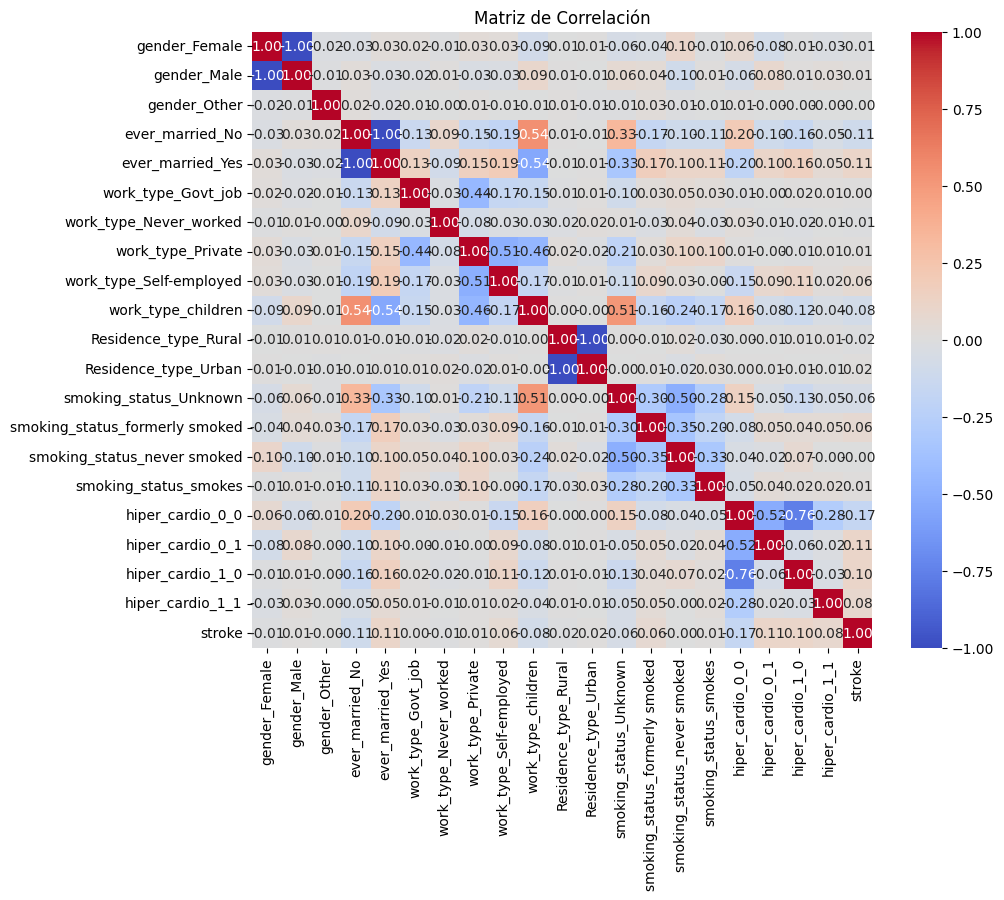

In [ ]:
# Calcular la matriz de correlación solo para columnas numéricas
corr_matrix = df_final.select_dtypes(include=['number']).corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matriz de Correlación')
plt.show()

**¿Qué es SMOTE?**

SMOTE significa Synthetic Minority Oversampling Technique (Técnica de sobremuestreo sintético de la clase minoritaria).
Es un método muy usado cuando tenemos un dataset desbalanceado, es decir, cuando una clase tiene muchos más ejemplos que la otra (como en tu caso: 96% “No Stroke” vs 4% “Stroke”).


**Problema del desbalanceo**

Si entrenas un modelo con datos desbalanceados:
El modelo aprende a predecir siempre la clase mayoritaria (en este caso, “No Stroke”).
Obtendremos un accuracy alto, pero el modelo fallará en detectar la clase minoritaria (“Sí Stroke”), que justamente es la más importante.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separar features y target
X = df_final.drop("stroke", axis=1)
y = df_final["stroke"]

# Dividir en train/test antes de aplicar SMOTE (¡muy importante!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Distribución original de y_train:")
print(y_train.value_counts())

# Aplicar SMOTE SOLO en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribución balanceada de y_train después de SMOTE:")
print(y_train_res.value_counts())

Distribución original de y_train:
stroke
0    3403
1     174
Name: count, dtype: int64
Distribución balanceada de y_train después de SMOTE:
stroke
0    3403
1    3403
Name: count, dtype: int64


# **ENTRENAMIENTO**

**4. Entrenaremos dos modelos principales:**

- **Random Forest**
- **XGBoost**

Usaremos el conjunto **balanceado con SMOTE** para el entrenamiento (`X_train_res`, `y_train_res`) y evaluaremos contra el **test original** (`X_test`, `y_test`) para medir el desempeño realista.  
Las métricas clave serán **Recall** (sensibilidad), **F1-score**, **ROC-AUC** y la **matriz de confusión**.


In [ ]:
# === Random Forest ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight=None # ya balanceamos con SMOTE
)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test)

# === XGBoost ===
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    scale_pos_weight=1 # no es necesario ajustar porque usamos SMOTE
)
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)

# === Evaluación comparativa ===
def evaluar_modelo(nombre, y_true, y_pred):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

resultados = []
resultados.append(evaluar_modelo("Random Forest (SMOTE)", y_test, y_pred_rf))
resultados.append(evaluar_modelo("XGBoost (SMOTE)", y_test, y_pred_xgb))

# Crear tabla comparativa
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# === Matriz de confusión Random Forest ===
print("\nMatriz de confusión Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# === Matriz de confusión XGBoost ===
print("\nMatriz de confusión XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

                  Modelo  Accuracy    Recall  F1-score   ROC-AUC
0  Random Forest (SMOTE)  0.836921  0.160000  0.087591  0.515871
1        XGBoost (SMOTE)  0.843444  0.146667  0.083969  0.512977

Matriz de confusión Random Forest:
[[1271  187]
 [  63   12]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1458
           1       0.06      0.16      0.09        75

    accuracy                           0.84      1533
   macro avg       0.51      0.52      0.50      1533
weighted avg       0.91      0.84      0.87      1533


Matriz de confusión XGBoost:
[[1282  176]
 [  64   11]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1458
           1       0.06      0.15      0.08        75

    accuracy                           0.84      1533
   macro avg       0.51      0.51      0.50      1533
weighted avg       0.91      0.84      0.87      1533



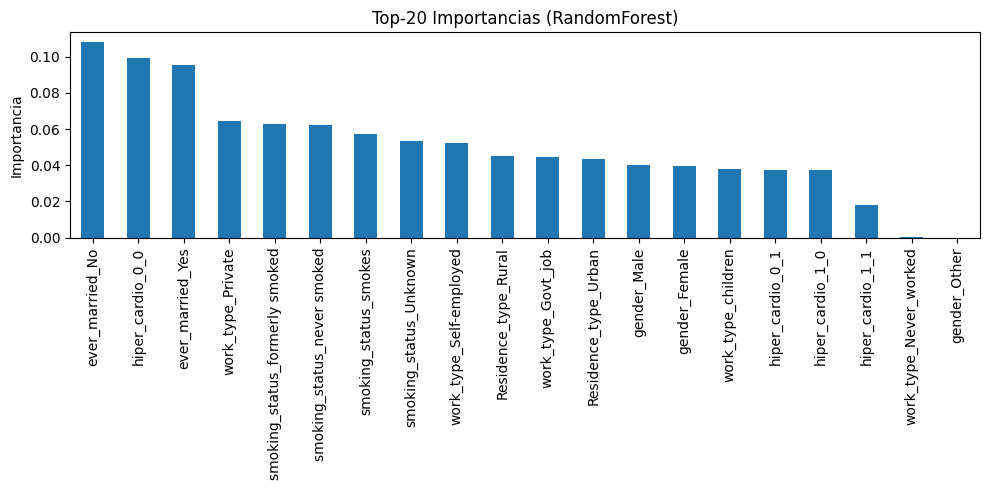

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importancias = pd.Series(rf_model.feature_importances_, index=X_test.columns)\
               .sort_values(ascending=False)[:20]  # top-20
plt.figure(figsize=(10,5))
importancias.plot(kind="bar")
plt.title("Top-20 Importancias (RandomForest)")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()


Estas son algunas de las features que tienen mayor relación para la predicción de stroke y como se puede verificar al crear variables adicionales ha mejorado la predicción.



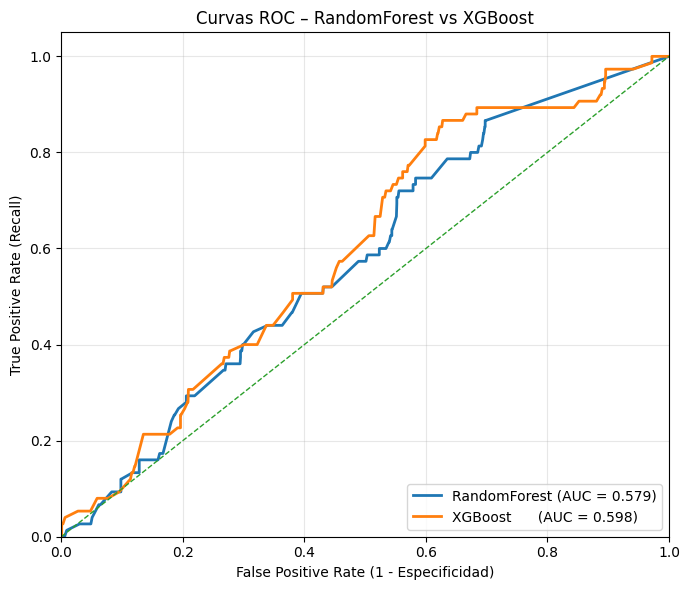

In [ ]:
from sklearn.metrics import roc_curve, auc

# Probabilidades de clase positiva
# Nota: para XGBClassifier, predict_proba está disponible por defecto
y_proba_rf  = rf_model.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Curvas ROC
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

roc_auc_rf  = auc(fpr_rf,  tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(fpr_rf,  tpr_rf,  lw=2, label=f"RandomForest (AUC = {roc_auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f"XGBoost      (AUC = {roc_auc_xgb:.3f})")

plt.plot([0,1],[0,1], linestyle="--", lw=1)  # línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curvas ROC – RandomForest vs XGBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **RandomizedSearchCV**

Aunque teniendo en cuenta que añadir features para mejorar la predicción no ha mejorado mucho y esto es visible con la curva ROC, el desbalance aun usando ESMOTE no mejora y lo siguiente para mejorar sería optimizar la hiperparametrización antes de entrenar, por motivos practicos y como vemos que XGBoost trabaja mejor solo se usará este para entrenar el modelo en adelante

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

# Definimos espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

# Instanciamos el modelo base
xgb_clf = XGBClassifier(
    random_state=42,
    scale_pos_weight=1,  # usamos SMOTE, así que no balanceamos manualmente
    use_label_encoder=False,
    eval_metric='logloss'
)

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  # puedes subir si tienes tiempo
    scoring=make_scorer(recall_score),
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Entrenamos
random_search.fit(X_train_res, y_train_res)

# Mostrar mejores parámetros
print("Mejores parámetros encontrados:")
print(random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:38:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores parámetros encontrados:
{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# Mejor modelo encontrado
best_xgb = random_search.best_estimator_

# Predicciones sobre test
y_pred_best = best_xgb.predict(X_test)
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))


Accuracy: 0.4729288975864318
Recall: 0.8266666666666667
F1-score: 0.13304721030042918
ROC-AUC: 0.718843164151806

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.45      0.62      1458
           1       0.07      0.83      0.13        75

    accuracy                           0.47      1533
   macro avg       0.53      0.64      0.38      1533
weighted avg       0.94      0.47      0.60      1533

Confusion Matrix:
[[663 795]
 [ 13  62]]


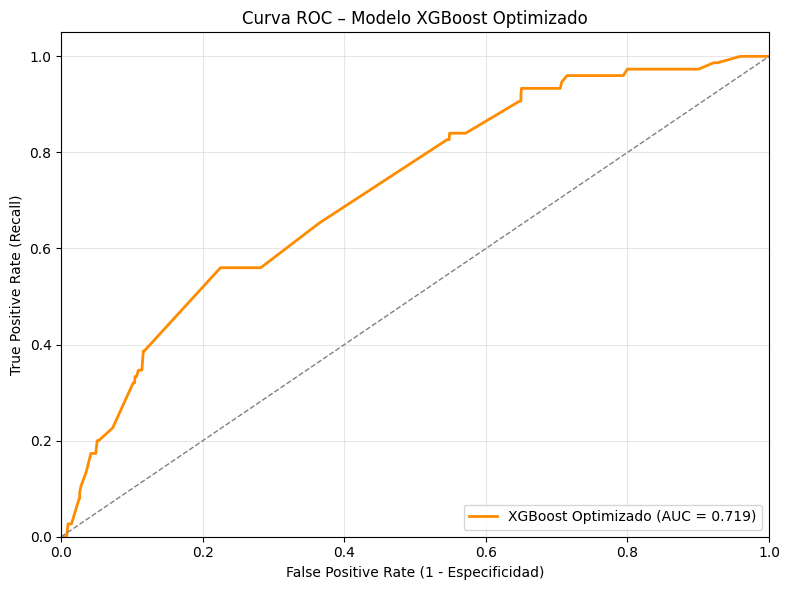

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilidades de clase 1
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"XGBoost Optimizado (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC – Modelo XGBoost Optimizado")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **CONCLUSIONES**

**Objetivo cumplido**

El objetivo principal de este proyecto fue construir un modelo de Machine Learning capaz de predecir la probabilidad de que un paciente sufra un accidente cerebrovascular, a partir de variables clínicas y demográficas. Se abordó el reto principal del dataset: el fuerte desbalance de clases (96% no-stroke vs 4% stroke).

**Técnicas aplicadas**

* Análisis exploratorio de datos (EDA) para comprender la distribución y patrones de las variables.

* Ingeniería de características médicas, como:

* Agrupación de edad (age_group)

* Clasificación del IMC (bmi_group)

* Combinación de hipertensión y enfermedad cardíaca (hiper_cardio)

* Balanceo de clases con SMOTE para evitar sesgos hacia la clase mayoritaria.

* Optimización del modelo usando RandomizedSearchCV para XGBoost.

* Evaluación detallada mediante métricas clínicas clave: Recall, F1-score y ROC-AUC.


**Resultados obtenidos**

El modelo final (XGBoost optimizado con SMOTE) logró un:

Recall (clase 1 – stroke): 83%

AUC-ROC: 0.72

Aunque el accuracy fue moderado (~47%) y el F1-score bajo (por alta cantidad de falsos positivos), este comportamiento es aceptable en contextos clínicos, donde es preferible un modelo que "se equivoque por exceso" antes que no detectar un paciente en riesgo.


**Interpretación clínica**

El modelo está orientado a detectar pacientes que podrían desarrollar un accidente cerebrovascular, incluso si eso implica algunas predicciones incorrectas. Esto es válido en medicina preventiva, donde los falsos positivos pueden simplemente derivarse a una evaluación médica adicional, mientras que los falsos negativos pueden tener consecuencias críticas.